This notebook uses the SMS Spam Collection dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection.

In [39]:
from collections import defaultdict
import random

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import numpy as np

random.seed(1234)

Start by loading the data and randomly separating it into train and test categories (2/3 into train, 1/3 into test). These are represented by `tr_data` and `te_data` which are of the form:
- `tr_data = {'ham': [message1, message2, message3, ...], 'spam': [message1, message2, message3, ...]}`
- `te_data = {'ham': [message1, message2, message3, ...], 'spam': [message1, message2, message3, ...]}`

In [3]:
# Load the data into 2/3 training and 1/3 testing
with open('SMSSpamCollection', 'r', encoding = 'utf-8') as file:
    data = [line for line in file]

random.shuffle(data)

split_index = 2 * len(data) // 3
tr_data_list = data[:split_index]
te_data_list = data[split_index:]

tr_data = defaultdict(lambda : list())
te_data = defaultdict(lambda : list())

for line in tr_data_list:
    line = line.strip().split('\t')
    assert len(line) == 2
    tr_data[line[0]].append(line[1])

for line in te_data_list:
    line = line.strip().split('\t')
    assert len(line) == 2
    te_data[line[0]].append(line[1])

In [12]:
# Print statistics about the data
print(f'TRAIN DATA:')
print(f'Number of ham messages: {len(tr_data["ham"])}')
print(f'Number of spam messages: {len(tr_data["spam"])}')
print(f'\nTEST DATA:')
print(f'Number of ham messages: {len(te_data["ham"])}')
print(f'Number of spam messages: {len(te_data["spam"])}')

TRAIN DATA:
Number of ham messages: 3212
Number of spam messages: 504

TEST DATA:
Number of ham messages: 1615
Number of spam messages: 243


Next, preprocess the data by tokenizing the messages, lowercasing each word, and lemmatizing each word. As a result, each message becomes:
- `message` $\rightarrow$ `[word1, word2, word3, ...]`

This mean that the `tr_data` and `te_data` data structures hold the following:
- `{'ham': [[m1w1, m1w2, m1w3, ...], [m2w1, m2w2, m2w3, ...], ...], 'spam': [[m1w1, m1w2, m1w3, ...], [m2w1, m2w2, m2w3, ...], ...]}`

In [20]:
# Data preparation: tokenize the messages, remove stop words, lemmatize and lowercase each word
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_preprocess(data):
    new_data = defaultdict(lambda : list())
    
    for message in data['ham']:
        new_data['ham'].append([lemmatizer.lemmatize(token.lower()) for token in word_tokenize(message) if token not in stop_words and len(token) > 0])

    for message in data['spam']:
        new_data['spam'].append([lemmatizer.lemmatize(token.lower()) for token in word_tokenize(message) if token not in stop_words and len(token) > 0])

    return new_data

tr_data = tokenize_and_preprocess(tr_data)
te_data = tokenize_and_preprocess(te_data)

Next, obtain the probability distribution of the words. `words` is a sorted list of every (preprocessed) word in the dataset. `ham_words` is a dictionary that contains the frequency of words in the ham training set. `spam_words` is the same but for the spam training set. These dictionaries are used to compute the probability of each word appearing in the ham/spam datasets. These probability distributions are stacked to form the observation state distribution (size `2 x n` which represents the 2 categories, ham and spam, and the `n` number of possible words).

Note that the order of words is maintained (increasing alphabetically) for consistency. This way, the first column in `obs_prob_matrix` represents the same word, the second column represents the same word, and so on.

In [22]:
# Data preparation: compute observation state distribution (probability distribution of words in training ham/spam datasets)
words = sorted(list({lemmatizer.lemmatize(word.lower()) for item in data for word in word_tokenize(item.split('\t')[1].strip()) if word not in stop_words and len(word) > 0}))
ham_words = {word: 0 for word in words}
spam_words = {word: 0 for word in words}

for line in tr_data['ham']:
    for word in line:
        ham_words[word] += 1

for line in tr_data['spam']:
    for word in line:
        spam_words[word] += 1

ham_probabilities = np.array([item[1] for item in sorted(list((word, freq) for word, freq in ham_words.items()))])
ham_probabilities = ham_probabilities / np.sum(ham_probabilities)
spam_probabilities = np.array([item[1] for item in sorted(list((word, freq) for word, freq in spam_words.items()))])
spam_probabilities = spam_probabilities / np.sum(spam_probabilities)

obs_prob_matrix = np.stack([ham_probabilities, spam_probabilities])

Initialize the HMM parameters. The starting probability distribution is `[0.5, 0.5]` to signify that either category (ham or spam) is equally likely. The transition matrix is initialized to `[[0.5, 0.5], [0.5, 0.5]]` to signify that transitioning to any state from any state is equally likely.

In [23]:
# Data preparation: initialize discrete HMM model
initial = np.array([0.5, 0.5])
T = np.array([[0.5, 0.5], [0.5, 0.5]])
O = obs_prob_matrix

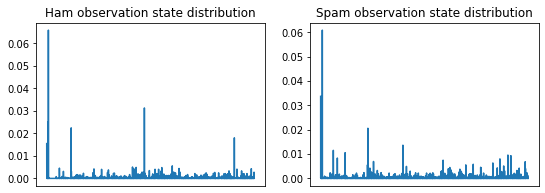

In [24]:
fig, axes = plt.subplots(1, 2, figsize = (9, 3))

axes[0].plot(O[0, :])
axes[0].set_title('Ham observation state distribution')
axes[0].xaxis.set_visible(False)

axes[1].plot(O[1, :])
axes[1].set_title('Spam observation state distribution')
axes[1].xaxis.set_visible(False)

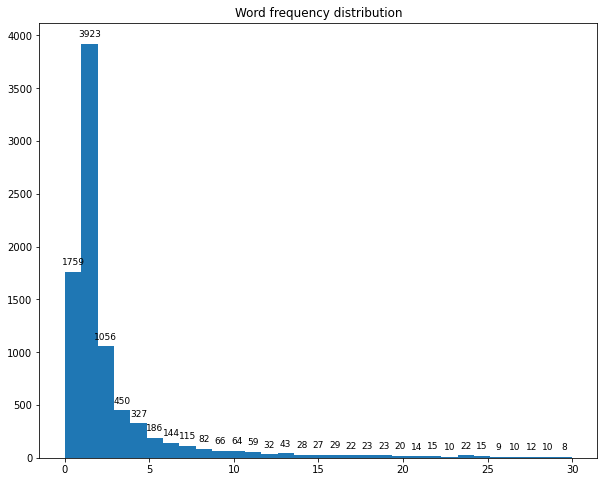

In [25]:
combined = sorted([ham_words[word] + spam_words[word] for word in words])

fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(combined, bins = 31, range = (0, 30))
ax.set_title('Word frequency distribution')

for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy = (rect.get_x() + rect.get_width() / 2, height), xytext = (0, 5), textcoords = 'offset points', ha = 'center', va = 'bottom', fontsize = 9)

Perform the Baum-Welch algorithm to optimize the HMM parameters.

In [26]:
# Training: perform Baum–Welch algorithm to optimize HMM parameters
def forward(V, T, O, initial_distribution):
    alpha = np.zeros((V.shape[0], T.shape[0]))
    alpha[0, :] = initial_distribution * O[:, V[0]]

    for i in range(1, V.shape[0]):
        for j in range(T.shape[0]):
            alpha[i, j] = alpha[i - 1] @ T[:, j] * O[j, V[i]]
        alpha[i] = alpha[i] / np.sum(alpha[i])

    return alpha


def backward(V, T, O):
    beta = np.zeros((V.shape[0], T.shape[0]))
    beta[V.shape[0] - 1] = np.ones((T.shape[0]))

    for i in range(V.shape[0] - 2, -1, -1):
        for j in range(T.shape[0]):
            beta[i, j] = (beta[i + 1] * O[:, V[i + 1]]) @ T[j, :]
        beta[i] = beta[i] / np.sum(beta[i])

    return beta


def baum_welch(V, T, O, initial_distribution, n_iter=100):
    M = T.shape[0]
    t = len(V)

    for n in range(n_iter):
        # Estimation
        alpha = forward(V, T, O, initial_distribution)
        beta = backward(V, T, O)

        xi = np.zeros((M, M, t - 1))
        for i in range(t - 1):
            denominator = (alpha[i, :].T @ T * O[:, V[i + 1]].T) @ beta[i + 1, :]
            for j in range(M):
                numerator = alpha[i, j] * T[j, :] * O[:, V[i + 1]].T * beta[i + 1, :].T
                xi[j, :, i] = numerator / denominator

        gamma = np.sum(xi, axis=1)

        # Maximization
        T = np.sum(xi, 2) / np.sum(gamma, axis=1).reshape((-1, 1))

        # Add additional T'th element in gamma
        gamma = np.hstack((gamma, np.sum(xi[:, :, t - 2], axis=0).reshape((-1, 1))))

        K = O.shape[1]
        denominator = np.sum(gamma, axis=1)
        for l in range(K):
            O[:, l] = np.sum(gamma[:, V == l], axis=1)

        O = np.divide(O, denominator.reshape((-1, 1)))

        T = np.array([T[i] / np.sum(T[i]) for i in range(T.shape[0])])

    return T, O

observation_sequence = np.array([words.index(w) for line in tr_data['ham'] + tr_data['spam'] for w in line])
T, O = baum_welch(observation_sequence, T, O, initial)

Test the accuracy of the trained HMM model by using the Viterbi algorithm and testing dataset.

In [27]:
# Testing: define Viterbi algorithm for classification task
def most_likely_state_sequence(T, O, initial, X):
    # Initialize the probability distribution table and the most likely previous state
    prob_table = np.zeros((len(X), len(T)))
    prev_most_likely = np.zeros((len(X), len(T)))

    prob_table[0] = initial

    # Forward pass through observation sequence
    for i in range(1, len(X)):
        for j in range(len(T)):
            prob_table[i, j] = np.max(prob_table[i - 1] * T[:, j]) * O[j, X[i]]            
            prev_most_likely[i, j] = np.argmax(prob_table[i - 1] * T[:, j])

        if not all(prob_table[i, :]): prev_most_likely[i, :] = np.random.choice(2, 2, p = [0.5, 0.5])

    # Backward pass through observation sequence to find most likely sequence
    sequence = [np.argmax(prob_table[-1])]
    for k in range(len(X) - 1, 0, -1):
        sequence.append(int(prev_most_likely[k][sequence[-1]]))

    # Return the output sequence
    return np.array(sequence[::-1])

In [34]:
def evaluate_accuracy(data, words, T, O, initial):
    true = []
    pred = []

    for line in data['ham']:
        true_label = 0  # Ham
        true.append(true_label)
        most_likely = most_likely_state_sequence(T, O, initial, [words.index(w) for w in line])

        for i in range(5):
            most_likely = np.append(most_likely, most_likely_state_sequence(T, O, initial, [words.index(w) for w in line]))

        bin_count = np.bincount(most_likely)
        predicted_label = np.argmax(bin_count)
        pred.append(predicted_label)

    for line in data['spam']:
        true_label = 1  # Spam
        true.append(true_label)
        most_likely = most_likely_state_sequence(T, O, initial, [words.index(w) for w in line])

        for i in range(5):
            most_likely = np.append(most_likely, most_likely_state_sequence(T, O, initial, [words.index(w) for w in line]))

        bin_count = np.bincount(most_likely)
        predicted_label = np.argmax(bin_count)
        pred.append(predicted_label)

    return true, pred

def calculate_accuracy(y_true, y_pred):
    correct_ham = sum((np.array(y_true) == 0) & (np.array(y_pred) == 0))
    correct_spam = sum((np.array(y_true) == 1) & (np.array(y_pred) == 1))
    
    ham_accuracy = correct_ham / sum(np.array(y_true) == 0)
    spam_accuracy = correct_spam / sum(np.array(y_true) == 1)
    overall_accuracy = (correct_ham + correct_spam) / len(y_true)
    
    return ham_accuracy, spam_accuracy, overall_accuracy

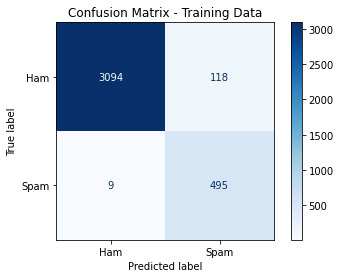

TRAINING DATA:
Ham accuracy: 0.9632627646326276
Spam accuracy: 0.9821428571428571
Overall accuracy: 0.9658234660925726


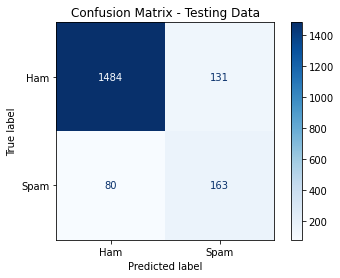


TESTING DATA:
Ham accuracy: 0.9188854489164087
Spam accuracy: 0.6707818930041153
Overall accuracy: 0.8864370290635092
Wall time: 26.5 s


In [40]:
%%time
# Testing: perform tests on training and testing data

train_y_true, train_y_pred = evaluate_accuracy(tr_data, words, T, O, initial)
train_cm = confusion_matrix(train_y_true, train_y_pred)
train_disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=['Ham', 'Spam'])
train_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Training Data')
plt.show()

train_ham_accuracy, train_spam_accuracy, train_overall_accuracy = calculate_accuracy(train_y_true, train_y_pred)

print(f'TRAINING DATA:')
print(f'Ham accuracy: {train_ham_accuracy}')
print(f'Spam accuracy: {train_spam_accuracy}')
print(f'Overall accuracy: {train_overall_accuracy}')

test_y_true, test_y_pred = evaluate_accuracy(te_data, words, T, O, initial)
test_cm = confusion_matrix(test_y_true, test_y_pred)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=['Ham', 'Spam'])
test_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Testing Data')
plt.show()

test_ham_accuracy, test_spam_accuracy, test_overall_accuracy = calculate_accuracy(test_y_true, test_y_pred)

print(f'\nTESTING DATA:')
print(f'Ham accuracy: {test_ham_accuracy}')
print(f'Spam accuracy: {test_spam_accuracy}')
print(f'Overall accuracy: {test_overall_accuracy}')